In [1]:
# 稠密连接网络
''' 
ResNet极⼤地改变了如何参数化深层⽹络中函数的观点。稠密连接⽹络（DenseNet）[Huang et al., 2017]在
某种程度上是ResNet的逻辑扩展。让我们先从数学上了解⼀下
-------------------------------------------------------------------------------------------
从ResNet到DenseNet
稠密⽹络主要由2部分构成：稠密块（dense block）和过渡层（transition layer）。前者定义如何连接输⼊和
输出，⽽后者则控制通道数量，使其不会太复杂
-------------------------------------------------------------------------------------------
稠密块体
DenseNet使⽤了ResNet改良版的“批量规范化、激活和卷积”架构（参⻅ 7.6节中的练习）。我们⾸先实现⼀
下这个架构
'''
import torch
from torch import nn
from d2l import torch as d2l

In [2]:
# ResNet改良版的“批量规范化、激活和卷积”架构
# 卷积块的 num_channels 对标 输出通道
def conv_block(input_channels, num_channels):
    return nn.Sequential(
        nn.BatchNorm2d(input_channels), nn.ReLU(), 
        nn.Conv2d(input_channels, num_channels, kernel_size=3, padding=1))

In [13]:
''' 
⼀个稠密块由多个卷积块组成，每个卷积块使⽤相同数量的输出通道。然⽽，在前向传播中，我们将每个卷
积块的输⼊和输出在通道维上连结。

'''
class DenseBlock(nn.Module):
    def __init__(self, num_convs, input_channels, num_channels):
        super(DenseBlock, self).__init__()
        layer = []
        # conv_block(input_channels, num_channels)
        # # 卷积块的通道数控制了输出通道数相对于输⼊通道数的增⻓，因此也被称为增⻓率（growth rate）
        for i in range(num_convs):
            layer.append(conv_block(
                num_channels * i + input_channels, num_channels))
        self.net = nn.Sequential(*layer)
    def forward(self, X):
        for blk in self.net:
            Y = blk(X)
            # 连接通道维度上每个块的输⼊和输出
            X = torch.cat((X, Y), dim=1) # 批量 通道 高 宽 dim=1 对应通道数
        return X

In [14]:
''' 
在下⾯的例⼦中，我们定义⼀个有2个conv_block且输出通道数为10的DenseBlock。使⽤通道数为3的输⼊时，
我们会得到通道数为3 (input_channels) + 2 × 10 (num_channels * i) = 23的输出。卷积块的通道数
控制了输出通道数相对于输⼊通道数的增⻓，因此也被称为增⻓率（growth rate）
'''
# blk 块 DenseBlock(num_convs, input_channels, num_channels)
blk = DenseBlock(2, 3, 10)
X = torch.randn(4, 3, 8, 8)
Y = blk(X)
Y.shape

torch.Size([4, 23, 8, 8])

In [16]:
# 过渡层
''' 
由于每个稠密块都会带来通道数的增加，使⽤过多则会过于复杂化模型。⽽过渡层可以⽤来控制模型复杂度。
它通过1 × 1卷积层来减⼩通道数，并使⽤步幅为2的平均汇聚层减半⾼和宽，从⽽进⼀步降低模型复杂度。

def conv_block(input_channels, num_channels):
    return nn.Sequential(
        nn.BatchNorm2d(input_channels), nn.ReLU(), 
        nn.Conv2d(input_channels, num_channels, kernel_size=3, padding=1))
'''
def transition_block(input_channels, num_channels):
    return nn.Sequential(
        nn.BatchNorm2d(input_channels), nn.ReLU(),
        nn.Conv2d(input_channels, num_channels, kernel_size=1), # 通过1×1卷积层来控制通道数
        nn.AvgPool2d(kernel_size=2, stride=2)) # 最大池化 高宽减半

In [17]:
# 对上⼀个例⼦中稠密块的输出使⽤通道数为10的过渡层。此时输出的通道数减为10，⾼和宽均减半。、
blk = transition_block(23, 10)
blk(Y).shape

torch.Size([4, 10, 4, 4])

In [18]:
# DenseNet模型
''' 
构造DenseNet模型。DenseNet⾸先使⽤同ResNet⼀样的单卷积层和最⼤汇聚层
---------------------------------------------------------------------------------------
ResNet的前两层跟之前介绍的GoogLeNet中的⼀样：在输出通道数为64、步幅为2的7 × 7卷积层后，接步幅
为2的3 × 3的最⼤汇聚层。不同之处在于ResNet每个卷积层后增加了批量规范化层。
'''
b1 = nn.Sequential(
    nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
    nn.BatchNorm2d(64), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [19]:
''' 
接下来，类似于ResNet使⽤的4个残差块，DenseNet使⽤的是4个稠密块。与ResNet类似，我们可以设置每个
稠密块使⽤多少个卷积层。这⾥我们设成4，从⽽与 7.6节的ResNet-18保持⼀致。稠密块⾥的卷积层通道数
（即增⻓率）设为32，所以每个稠密块将增加128个通道。

在每个模块之间，ResNet通过步幅为2的残差块减⼩⾼和宽，DenseNet则使⽤过渡层来减半⾼和宽，并减半
通道数。
----------------------------------------------------------------------------------------
GoogLeNet在后⾯接了4个由Inception块组成的模块。ResNet则使⽤4个由残差块组成的模块，每个模块使⽤
若⼲个同样输出通道数的残差块。第⼀个模块的通道数同输⼊通道数⼀致。由于之前已经使⽤了步幅为2的
最⼤汇聚层，所以⽆须减⼩⾼和宽。之后的每个模块在第⼀个残差块⾥将上⼀个模块的通道数翻倍，并将⾼
和宽减半。
----------------------------------------------------------------------------------------
# num_channels为当前的通道数,对应input_channels
# 卷积块的通道数控制了输出通道数相对于输⼊通道数的增⻓，因此也被称为增⻓率(growth rate)
# DenseBlock(num_convs, input_channels, num_channels)
# conv_block(input_channels, num_channels)
# 此处的 num_channels 为 input_channels, growth_rate 为 num_channels
# layer.append(conv_block(num_channels * i + input_channels, num_channels))
# transition_block(input_channels, num_channels)
'''
num_channels, growth_rate = 64, 32 # 稠密块⾥的卷积层通道数(即增⻓率)设为32
num_convs_in_dense_blocks = [4, 4, 4, 4] # 稠密块中的卷积数量
blks = []
for i, num_convs in enumerate(num_convs_in_dense_blocks): #  枚举 卷积块数量4
    blks.append(DenseBlock(num_convs, num_channels, growth_rate))
    
    # 上⼀个稠密块的输出通道数  for i in range(num_convs) 因为求上个稠密块,所以直接使用num_convs
    # # layer.append(conv_block(num_channels * i + input_channels, num_channels))
    # 增长率为32,每个稠密块有4个卷积块,所以每个稠密块将增加128个通道
    num_channels += num_convs * growth_rate # num_channels * i + input_channels
    
    # 在稠密块之间添加⼀个转换层，使通道数量减半
    if i != len(num_convs_in_dense_blocks) - 1: # 若i不等于3,即每个稠密块(4个卷积块)之间添加过渡层
        blks.append(transition_block(num_channels, num_channels // 2)) # 输出通道为输入的一半
        num_channels = num_channels // 2 # 更新输入通道数的数值

In [26]:
# 测试
''' 
print(len(num_convs_in_dense_blocks)-1 )
for i, num_convs in enumerate(num_convs_in_dense_blocks):
    print(num_convs)
'''


3
4
4
4
4


In [20]:
# 与ResNet类似，最后接上全局汇聚层和全连接层来输出结果。
# blks 4个稠密块,每个稠密块含有4个卷积块
net = nn.Sequential(
    b1, *blks,
    nn.BatchNorm2d(num_channels), nn.ReLU(),
    nn.AdaptiveAvgPool2d((1, 1)),
    nn.Flatten(),
    nn.Linear(num_channels, 10))

loss 0.140, train acc 0.948, test acc 0.837
3214.0 examples/sec on cuda:0


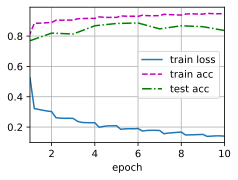

In [21]:
# 训练模型
'由于这⾥使⽤了⽐较深的⽹络，本节⾥我们将输⼊⾼和宽从224降到96来简化计算'
lr, num_epochs, batch_size = 0.1, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96) # 高宽减为96
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

In [ ]:
''' 
⼩结
• 在跨层连接上，不同于ResNet中将输⼊与输出相加，稠密连接⽹络（DenseNet）在通道维上连结输⼊与输出
• DenseNet的主要构建模块是稠密块和过渡层
• 在构建DenseNet时，我们需要通过添加过渡层来控制⽹络的维数，从⽽再次减少通道的数量
'''